In [1]:
# Importing Libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image
warnings.filterwarnings('ignore')

### Load and Check Data

In [9]:
books = pd.read_csv('C:/Users/Moin Dalvi/Documents/EXcelR Study and Assignment Material/Data Science Assignments/Recommendation Systems/book.csv', encoding='Latin1')
books

,Unnamed: 0,User.ID,Book.Title,Book.Rating
0,1,276726,Classical Mythology,5
1,2,276729,Clara Callan,3
2,3,276729,Decision in Normandy,6
3,4,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,5,276737,The Mummies of Urumchi,6
...,...,...,...,...
9995,9996,162121,American Fried: Adventures of a Happy Eater.,7
9996,9997,162121,Cannibal In Manhattan,9
9997,9998,162121,How to Flirt: A Practical Guide,7
9998,9999,162121,Twilight,8


### About Dataset<a class="anchor" id="1.1"></a>
Contains 2182 users providing ratings from 0 as minimum and 10 as maximum about 9659 books.

### Data Exploration<a class="anchor" id="2"></a>

In [17]:
print('Number of Unique Users are {}'.format(len(books['user_id'].unique())))

Number of Unique Users are 2182


In [20]:
print('Number of Unique Books are {}'.format(len(books['title'].unique())))

Number of Unique Books are 9659


In [10]:
books['rating'].value_counts()

8     2283
7     2076
10    1732
9     1493
5     1007
6      920
4      237
3      146
2       63
1       43
Name: rating, dtype: int64

In [14]:
books['user_id'].unique()

array([276726, 276729, 276736, ..., 162113, 162121, 162129], dtype=int64)

In [26]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  10000 non-null  int64 
 1   title    10000 non-null  object
 2   rating   10000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 234.5+ KB


In [29]:
books.rating.describe()

count    10000.00000
mean         7.56630
std          1.82152
min          1.00000
25%          7.00000
50%          8.00000
75%          9.00000
max         10.00000
Name: rating, dtype: float64

In [77]:
books.describe()

,user_id,rating
count,10000.000000,10000.00000
mean,95321.249800,7.56630
std,117645.703609,1.82152
min,8.000000,1.00000
25%,2103.000000,7.00000
50%,3757.000000,8.00000
75%,162052.000000,9.00000
max,278854.000000,10.00000


In [60]:
books.isnull().any()

user_id    False
title      False
rating     False
dtype: bool

In [62]:
books.isnull().sum()

user_id    0
title      0
rating     0
dtype: int64

In [73]:
books.duplicated().sum()

2

In [72]:
books[books.duplicated()].shape

(2, 3)

In [74]:
books[books.duplicated()]

,user_id,title,rating
5051,2152,Le nouveau soleil de Teur,7
7439,3757,The Magician's Tale,7


Let's create a ratings dataframe with average rating and number of ratings:

In [81]:
books.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Dr Mommy (From Here To Maternity) (Silhouette Desire, 1269)                                                           10.0
The Piano Man's Daughter                                                                                              10.0
Private Screening                                                                                                     10.0
The Pilates Body: The Ultimate At-Home Guide to Strengthening, Lengthening, and Toning Your Body--Without Machines    10.0
Desert Solitaire                                                                                                      10.0
Name: rating, dtype: float64

As we do not know the number of times the above 10 Rated books are rated we cannot take these ratings into consideration until a number of Users have rated the same books a considerate times

In [83]:
books.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

title
Fahrenheit 451                                     5
Ender's Game (Ender Wiggins Saga (Paperback))      4
Stardust                                           4
Vanished                                           4
Charlie and the Chocolate Factory                  4
The Subtle Knife (His Dark Materials, Book 2)      4
The Amber Spyglass (His Dark Materials, Book 3)    4
The Golden Compass (His Dark Materials, Book 1)    3
Pet Sematary                                       3
My Side of the Mountain                            3
Name: rating, dtype: int64

In [11]:
ratings = pd.DataFrame(books.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
"Jason, Madison &amp",8.0
Other Stories;Merril;1985;McClelland &amp,6.0
Repairing PC Drives &amp,4.0
'48,7.0
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,8.0


In [13]:
ratings['num of ratings'] = pd.DataFrame(books.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
"Jason, Madison &amp",8.0,1
Other Stories;Merril;1985;McClelland &amp,6.0,1
Repairing PC Drives &amp,4.0,1
'48,7.0,1
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,8.0,1


### Data Visualization<a class="anchor" id="3"></a>

<AxesSubplot:>

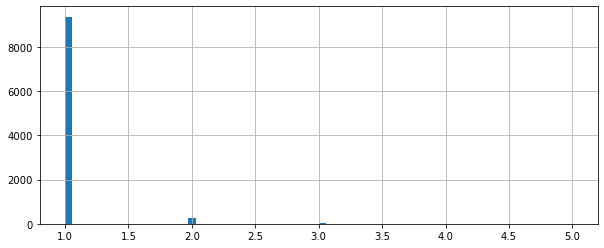

In [88]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

##### Observation: Maximum Number of Books are Rated only Once 

<AxesSubplot:>

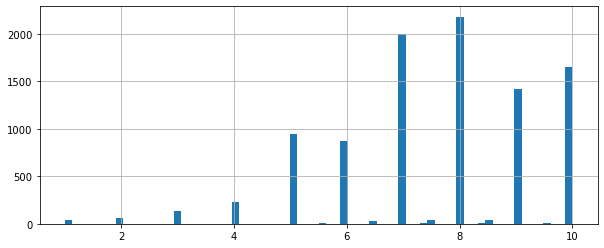

In [89]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

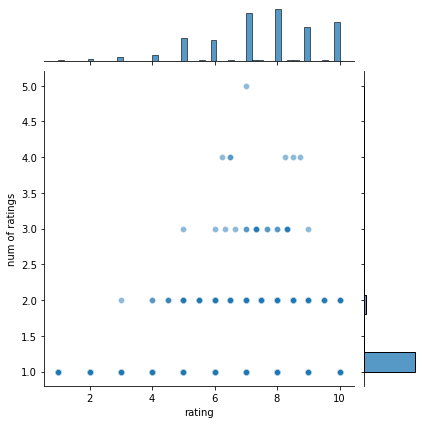

In [90]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)

Text(0.5, 1.0, 'Ratings Frequency')

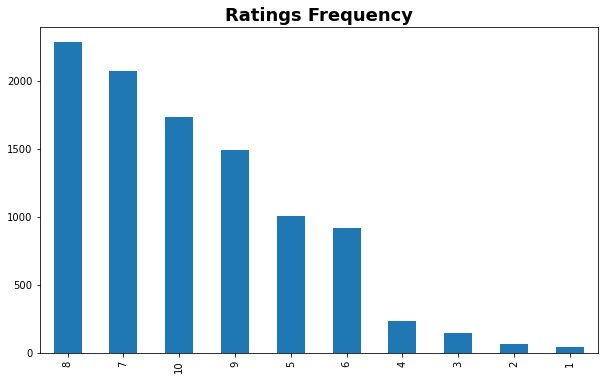

In [31]:
plt.figure(figsize=(10,6))
books['rating'].value_counts().plot(kind='bar')
plt.title('Ratings Frequency',  fontsize = 18, fontweight = 'bold')

### Observations:
+ #### Most Frequent Ratings by Users are: 8,7 and 10

In [78]:
top_books = books['title'].value_counts().head(10)
top_books.index

Index(['Fahrenheit 451', 'The Subtle Knife (His Dark Materials, Book 2)',
       'Stardust', 'Charlie and the Chocolate Factory',
       'Ender's Game (Ender Wiggins Saga (Paperback))',
       'The Amber Spyglass (His Dark Materials, Book 3)', 'Vanished',
       'Pet Sematary', 'Life Is Elsewhere', 'The Street Lawyer'],
      dtype='object')

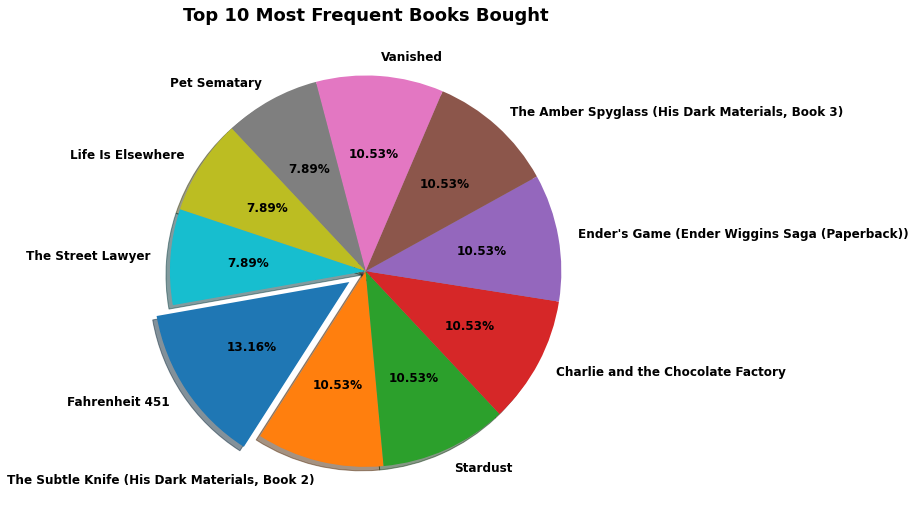

In [80]:
plt.figure(figsize = (16,9))
plt.pie(top_books,
       labels=top_books.index,
       explode = [0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
       autopct= '%.2f%%',
       shadow= True,
       startangle= 190,
       textprops = {'size':'large',
                   'fontweight':'bold',
                    'rotation':'0',
                   'color':'black'})
#plt.legend(loc= 'best')
plt.title("Top 10 Most Frequent Books Bought", fontsize = 18, fontweight = 'bold')
plt.show()

### Data Pre-Processing<a class="anchor" id="4"></a>

In [10]:
# Renaming the columns name
books.rename({'Unnamed: 0':'index','User.ID':'user_id','Book.Title':'title','Book.Rating':'rating'}, axis= 1, inplace =True)
books.set_index('index', inplace=True)
books

,user_id,title,rating
index,,,
1,276726,Classical Mythology,5
2,276729,Clara Callan,3
3,276729,Decision in Normandy,6
4,276736,Flu: The Story of the Great Influenza Pandemic...,8
5,276737,The Mummies of Urumchi,6
...,...,...,...
9996,162121,American Fried: Adventures of a Happy Eater.,7
9997,162121,Cannibal In Manhattan,9
9998,162121,How to Flirt: A Practical Guide,7


### Collaborative Book Recommendation System<a class="anchor" id="5"></a>

* **Item Based Collaborative Filtering** - Instead of measuring the similarity between users, the item-based CF recommends items based on their similarity with the items that the target user rated. Likewise, the similarity can be computed with Pearson Correlation or Cosine Similarity. The major difference is that, with item-based collaborative filtering, we fill in the blank vertically, as oppose to the horizontal manner that user-based CF does. The following table shows how to do so for the movie Me Before You.
![](https://cdn-images-1.medium.com/max/1000/1*LqFnWb-cm92HoMYBL840Ew.png)

It successfully avoids the problem posed by dynamic user preference as item-based CF is more static. However, several problems remain for this method. First, the main issue is ***scalability***. The computation grows with both the customer and the product. The worst case complexity is O(mn) with m users and n items. In addition, ***sparsity*** is another concern. Take a look at the above table again. Although there is only one user that rated both Matrix and Titanic rated, the similarity between them is 1. In extreme cases, we can have millions of users and the similarity between two fairly different movies could be very high simply because they have similar rank for the only user who ranked them both.



### Creating Pivot Table<a class="anchor" id="5.1"></a>

In [5]:
user_books_df = books.pivot_table(index='user_id',columns = 'title', values = 'rating').fillna(0)
user_books_df

title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
user_id,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0


In [6]:
# Calculating Cosine Similarity between Users
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation, jaccard

In [14]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Fahrenheit 451,7.000000,5
Ender's Game (Ender Wiggins Saga (Paperback)),6.250000,4
Stardust,8.500000,4
Vanished,6.500000,4
Charlie and the Chocolate Factory,6.500000,4
"The Subtle Knife (His Dark Materials, Book 2)",8.750000,4
"The Amber Spyglass (His Dark Materials, Book 3)",8.250000,4
"The Golden Compass (His Dark Materials, Book 1)",8.333333,3
Pet Sematary,7.666667,3


In [56]:
stardust_user_ratings = user_books_df['Stardust']
fahrenheit_user_rating = user_books_df['Fahrenheit 451']
fahrenheit_user_rating.head()

user_id
8     0.0
9     0.0
10    0.0
12    0.0
14    0.0
Name: Fahrenheit 451, dtype: float64

We can then use corrwith() method to get correlations between two pandas series:

In [58]:
similar_to_fahrenheit = user_books_df.corrwith(fahrenheit_user_rating)
similar_to_stardust = user_books_df.corrwith(stardust_user_ratings)

In [59]:
corr_fahrenheit = pd.DataFrame(similar_to_fahrenheit,columns=['Correlation'])
corr_fahrenheit.dropna(inplace=True)
corr_fahrenheit.head()

,Correlation
title,
"Jason, Madison &amp",-0.000958
Other Stories;Merril;1985;McClelland &amp,-0.000958
Repairing PC Drives &amp,-0.000958
'48,-0.000958
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,-0.000958


Now if we sort the dataframe by correlation, we should get the most similar movies, however note that we get some results that don't really make sense. This is because there are a lot of movies only watched once by users who also watched star wars (it was the most popular movie)

In [60]:
corr_fahrenheit.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Fahrenheit 451,1.000000
The Day I Swapped My Dad for 2 Goldfish,0.596326
A la vora del pou (El BalancÃ­),0.596326
Les illes grogues: Tres novelÂ¨les romÃ ntiques (El BalancÃ­),0.596326
The Ambassador's Women,0.596326
"Dream Country (Sandman, Book 3)",0.596326
"For The Love Of Beau (Delta Justice) (Delta Justice , No 9)",0.596326
"Father Of Two (The Daddy School) (Harlequin Superromance, No 771)",0.596326
Silent Witness,0.596326


Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).

In [87]:
corr_fahrenheit = corr_fahrenheit.join(ratings['rating'])
corr_fahrenheit.head()

,Correlation,num of ratings,rating
title,,,
"Jason, Madison &amp",-0.000958,1,8.0
Other Stories;Merril;1985;McClelland &amp,-0.000958,1,6.0
Repairing PC Drives &amp,-0.000958,1,4.0
'48,-0.000958,1,7.0
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,-0.000958,1,8.0


Okay! Now that we have a general idea of what the data looks like, let's move on to creating a simple recommendation system:

### Recommending Similar Books Using  Correlation<a class="anchor" id="5.2"></a>
#### Based on Ratings
Now let's create a matrix that has the user ids on one axis and the movie title on another axis. Each cell will then consist of the rating the users gave to that Book. Note there will be a lot of NaN values, because most people have not given rating to most of the books.

In [89]:
corr_fahrenheit[corr_fahrenheit['rating']>5].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings,rating
title,,,
Fahrenheit 451,1.000000,5,7.0
The Day I Swapped My Dad for 2 Goldfish,0.596326,1,9.0
"Julia (Circle Of Friends) (Harlequin Superromance, 813)",0.596326,1,7.0
The Princess Bride: S. Morgenstern's Classic Tale of True Love and High Adventure (The 'Good Parts' Version),0.596326,1,7.0
Contes de fÃ?Â©es Ã?Â l'usage des moyennes personnes,0.596326,1,7.0


In [91]:
corr_stardust = pd.DataFrame(similar_to_stardust,columns=['Correlation'])
corr_stardust.dropna(inplace=True)
corr_stardust = corr_stardust.join(ratings['num of ratings'])
corr_stardust[corr_stardust['num of ratings']>4].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Fahrenheit 451,-0.001908,5


## Collaborative Recommender System Using Cosine Similarity<a class="anchor" id="5.3"></a>

### **Collaborative Filtering**

Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers.
It is basically of two types:-

*  **User based filtering**-  These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity.
This filtering technique can be illustrated with an example. In the following matrixes, each row represents a user, while the columns correspond to different movies except the last one which records the similarity between that user and the target user. Each cell represents the rating that the user gives to that movie. Assume user E is the target.
![](https://cdn-images-1.medium.com/max/1000/1*9NBFo4AUQABKfoUOpE3F8Q.png)

Since user A and F do not share any movie ratings in common with user E, their similarities with user E are not defined in Pearson Correlation. Therefore, we only need to consider user B, C, and D. Based on Pearson Correlation, we can compute the following similarity.
![](https://cdn-images-1.medium.com/max/1000/1*jZIMJzKM1hKTFftHfcSxRw.png)

From the above table we can see that user D is very different from user E as the Pearson Correlation between them is negative. He rated Me Before You higher than his rating average, while user E did the opposite. Now, we can start to fill in the blank for the movies that user E has not rated based on other users.
![](https://cdn-images-1.medium.com/max/1000/1*9TC6BrfxYttJwiATFAIFBg.png)

Although computing user-based CF is very simple, it suffers from several problems. One main issue is that users’ preference can change over time. It indicates that precomputing the matrix based on their neighboring users may lead to bad performance. To tackle this problem, we can apply item-based CF.

In [65]:
user_books_df.head()

title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
user_id,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Calculating Cosine Similarity between Users
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation, jaccard

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the [cosine similarity scores](https://en.wikipedia.org/wiki/Cosine_similarity). There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two books. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:
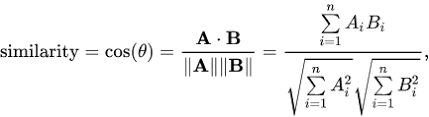

In [66]:
user_sim = 1 - pairwise_distances(user_books_df.values, metric = 'cosine')
user_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [67]:
# Store the results in a dataframe
user_sim_df = pd.DataFrame(user_sim)
user_sim_df

,0,1,2,3,4,5,6,7,8,9,...,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [68]:
user_sim_df.iloc[:5,:5]

,0,1,2,3,4
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0


In [69]:
np.fill_diagonal(user_sim, 0)
user_sim_df.iloc[0:5,0:5]

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [70]:
# Set the index and column name to user Ids
user_sim_df.index = list(user_books_df.index)
user_sim_df.columns = list(user_books_df.index)
user_sim_df

,8,9,10,12,14,16,17,19,22,26,...,278831,278832,278836,278843,278844,278846,278849,278851,278852,278854
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
user_id_eight = user_sim_df.sort_values([9], ascending=False).head(100)
user_id_eight[9]

8         0.0
161755    0.0
161744    0.0
161749    0.0
161750    0.0
         ... 
161441    0.0
161436    0.0
161434    0.0
161431    0.0
161423    0.0
Name: 9, Length: 100, dtype: float64

In [74]:
books[(books['user_id']==8) | (books['user_id']==14)]

,user_id,title,rating
index,,,
2400,8,Ancient Celtic Romances,5
2401,8,The Western way: A practical guide to the West...,5
2402,8,Wings,5
2403,8,Truckers,5
2404,8,Keepers of the Earth Teachers Guide,6
2405,8,The Celts Activity Book,6
2406,8,The Art Of Celtia,7
2410,14,COPS,5
2411,14,A Cold Heart: An Alex Delaware Novel,5


In [76]:
# Most Similar Users
user_sim_df.idxmax(axis=1)

8              8
9              8
10             8
12             8
14             8
           ...  
278846         8
278849         8
278851    278202
278852         8
278854         8
Length: 2182, dtype: int64

In [81]:
books[(books['user_id']==8) | (books['user_id']==14)]

,user_id,title,rating
index,,,
2400,8,Ancient Celtic Romances,5
2401,8,The Western way: A practical guide to the West...,5
2402,8,Wings,5
2403,8,Truckers,5
2404,8,Keepers of the Earth Teachers Guide,6
2405,8,The Celts Activity Book,6
2406,8,The Art Of Celtia,7
2410,14,COPS,5
2411,14,A Cold Heart: An Alex Delaware Novel,5


### Recommnedation Based on Cosine Similarity<a class="anchor" id="5.4"></a>

In [82]:
def give_reco(customer_id):
    tem = list(user_sim_df.sort_values([customer_id],ascending=False).head(100).index)
    #print('similar customer ids:',tem)
    movie_list=[]
    for i in tem:
        movie_list=movie_list+list(books[books['user_id']==i]['title'])
    #print('Common movies within customer',movie_list)
    return set(movie_list)-set(books[books['user_id']==customer_id]['title'])

In [83]:
give_reco(14)

{"'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities",
 '20,001 Names for Baby',
 '24 Hours',
 '500 palabras nuevas para ti / 500 Words To Grow On',
 'A Cat in the Manger: An Alice Nestleton Mystery (Alice Nestleton Mysteries (Paperback))',
 'A Certain Justice: A Novel',
 "A Child's Night Dream",
 'A Darkness More Than Night',
 'A Dog Year: Twelve Months, Four Dogs, and Me',
 "A False Sense of Well Being (Ballantine Reader's Circle)",
 'A Flash in the Pan: 100 Fast and Furious Recipes for Wok and Stir-Fry',
 'A Free Man of Color (Benjamin January (Paperback))',
 'A GATHERING OF SAINTS',
 'A Lady Never Trifles with Thieves',
 'A Letter of Mary (Mary Russell Novels (Paperback))',
 'A Letter to Harvey Milk: Short Stories',
 'A Light in the Attic',
 'A Pocket Guide to Oahu',
 "A Single Tear: A Family's Persecution, Love, and Endurance in Communist China",
 'A Wreath for Rivera',
 'A lexicon of Jewish cooking: A collection of folklore, foodlore, history, customs, and reci

In [84]:
give_reco(8)

{"'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities",
 '20,001 Names for Baby',
 '24 Hours',
 '500 palabras nuevas para ti / 500 Words To Grow On',
 'A Cat in the Manger: An Alice Nestleton Mystery (Alice Nestleton Mysteries (Paperback))',
 'A Certain Justice: A Novel',
 "A Child's Night Dream",
 'A Darkness More Than Night',
 'A Dog Year: Twelve Months, Four Dogs, and Me',
 "A False Sense of Well Being (Ballantine Reader's Circle)",
 'A Flash in the Pan: 100 Fast and Furious Recipes for Wok and Stir-Fry',
 'A Free Man of Color (Benjamin January (Paperback))',
 'A GATHERING OF SAINTS',
 'A Lady Never Trifles with Thieves',
 'A Letter of Mary (Mary Russell Novels (Paperback))',
 'A Letter to Harvey Milk: Short Stories',
 'A Light in the Attic',
 'A Pocket Guide to Oahu',
 "A Single Tear: A Family's Persecution, Love, and Endurance in Communist China",
 'A Wreath for Rivera',
 'A lexicon of Jewish cooking: A collection of folklore, foodlore, history, customs, and reci